In [1]:
import numpy as np
import pandas as pd
import jax.numpy as jnp
import matplotlib.pyplot as plt
import seaborn as sns
import colorcet as cc

from tqdm.auto import tqdm
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from aging.plotting import (
    figure,
    format_plots,
    add_identity,
    legend,
    PLOT_CONFIG,
    save_factory,
    COLORMAPS
)
from copy import deepcopy
from toolz import reduce, valmap, keyfilter, pluck, dissoc
from aging.behavior.bio_age_model import (
    fit_model,
    masked_xval,
    model_fun_v6,
    get_biological_age,
    compute_concentrations,
    concentration_interpolation,
    create_masks,
    expected_counts,
    compute_heldout_r2,
    model_setup,
)
from scipy.spatial.distance import pdist, squareform

In [2]:
format_plots()
saver = save_factory(PLOT_CONFIG.save_path / "fig5-bambi", tight_layout=False)

In [3]:
def zscore(ser: pd.Series):
    return (ser - ser.mean()) / ser.std()


def demean(ser: pd.Series):
    return ser - ser.mean()


def quantile(n):
    def percentile_(x):
        return x.quantile(n)
    percentile_.__name__ = 'q_{:0.02f}'.format(n)
    return percentile_

## Load male/female dfs

In [4]:
def load_male_long_df():
    keep_syllables = np.loadtxt('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/to_keep_syllables_raw.txt', dtype=int)
    df = pd.read_parquet(
        "/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/longtogeny_v2_males_raw_counts_matrix_v00.parquet"
    )
    size_df = pd.read_parquet(
        '/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/longtogeny_v2_males_mouse_area_df_v00.parquet'
    )

    df = df[keep_syllables]
    df = df.join(size_df[['quant_0.5']])

    idx_names = df.index.names
    age = df.index.get_level_values('age')

    bins = pd.cut(age, 75, labels=False)

    sample = df.reset_index().groupby(['mouse', bins], observed=True).first().droplevel(1)
    sample = sample.reset_index().set_index(idx_names)

    age_cut = pd.cut(sample.index.get_level_values('age'), 11)

    sample['quant_0.5'] = zscore(sample.groupby(age_cut, observed=True)['quant_0.5'].transform(demean))

    return sample


def load_female_long_df():
    keep_syllables = np.loadtxt('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/to_keep_syllables_raw.txt', dtype=int)
    df = pd.read_parquet(
        "/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/longtogeny_v2_females_raw_counts_matrix_v00.parquet"
    )
    size_df = pd.read_parquet(
        '/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/longtogeny_v2_females_mouse_area_df_v00.parquet'
    )

    df = df[keep_syllables]
    df = df.join(size_df[['quant_0.5']])

    idx_names = df.index.names
    age = df.index.get_level_values('age')

    bins = pd.cut(age, 75, labels=False)

    sample = df.reset_index().groupby(['mouse', bins], observed=True).first().droplevel(1)
    sample = sample.reset_index().set_index(idx_names)

    age_cut = pd.cut(sample.index.get_level_values('age'), 11)

    sample['quant_0.5'] = zscore(sample.groupby(age_cut, observed=True)['quant_0.5'].transform(demean))

    return sample

In [5]:
m_df = load_male_long_df()
m_size_col = m_df['quant_0.5']
m_df = m_df.drop(columns=['quant_0.5'])

f_df = load_female_long_df()
f_size_col = f_df['quant_0.5']
f_df = f_df.drop(columns=['quant_0.5'])

df = pd.concat([m_df, f_df])
size_col = pd.concat([m_size_col, f_size_col])
sort_idx = np.argsort(df.to_numpy().sum(0))[::-1]

label_encoder = OneHotEncoder(sparse_output=False, dtype=np.float32)
sex_id = label_encoder.fit_transform(np.hstack([np.zeros(len(df) - len(f_df)), np.ones(len(f_df))])[:, None]).T

mouse_ids = label_encoder.fit_transform(df.index.get_level_values("mouse").to_numpy()[:, None]).T

syllable_counts_jax = jnp.array(df.astype('float32'))
age = jnp.array(df.index.get_level_values('age'))

In [6]:
sex_id.shape

(2, 2599)

In [7]:
mouse_ids.shape

(40, 2599)

In [8]:
features = {
    "ages": age,  # models >= 1
    "counts": syllable_counts_jax + 1,  # models >= 1
    "sizes": size_col.to_numpy(),  # models > 1
    "sex": sex_id,
    "mice": mouse_ids,
}

hypparams = {
    "log_age": True,
    "min_age": 1,
    "max_age": 150,
    "age_sd": 0.5,  # weeks
    # "age_sd": 10,  # weeks
    "n_age_samples": 1500,
    "n_splines": 4,
    "n_syllables": syllable_counts_jax.shape[1],
    "n_development_splines": 4,
    "n_sex_splines": 4,
    "scale": 150,
    "normalize_by_softmax": True,
    "n_keep_sylls": 25,
    "n_sessions": len(syllable_counts_jax),
    "n_animals": len(mouse_ids),
    "n_sexes": len(sex_id),
    "lr": 0.2,
    "n_opt_iter": 450,
}

In [9]:
out_log = masked_xval(features, hypparams, 6, 4)

  0%|          | 0/4 [00:00<?, ?it/s]

In [10]:
features = {
    "ages": age,  # models >= 1
    "counts": syllable_counts_jax + 1,  # models >= 1
    "sizes": size_col.to_numpy(),  # models > 1
    "sex": sex_id,
    "mice": mouse_ids,
}

hypparams = {
    "log_age": False,
    "min_age": 1,
    "max_age": 150,
    # "age_sd": 0.5,  # weeks
    "age_sd": 10,  # weeks
    "n_age_samples": 1500,
    "n_splines": 4,
    "n_syllables": syllable_counts_jax.shape[1],
    "n_development_splines": 4,
    "n_sex_splines": 4,
    "scale": 150,
    "normalize_by_softmax": True,
    "n_keep_sylls": 25,
    "n_sessions": len(syllable_counts_jax),
    "n_animals": len(mouse_ids),
    "n_sexes": len(sex_id),
    "lr": 0.2,
    "n_opt_iter": 450,
}

In [11]:
out_logless = masked_xval(features, hypparams, 6, 4)

  0%|          | 0/4 [00:00<?, ?it/s]

In [18]:
features = {
    "ages": age,  # models >= 1
    "counts": syllable_counts_jax + 1,  # models >= 1
    "sizes": size_col.to_numpy(),  # models > 1
    "sex": sex_id,
    "mice": mouse_ids,
}

hypparams = {
    "log_age": True,
    "min_age": 1,
    "max_age": 150,
    "age_sd": 2,  # weeks
    # "age_sd": 10,  # weeks
    "n_age_samples": 1500,
    "n_splines": 4,
    "n_syllables": syllable_counts_jax.shape[1],
    "n_development_splines": 4,
    "n_sex_splines": 4,
    "scale": 150,
    "normalize_by_softmax": True,
    "n_keep_sylls": 25,
    "n_sessions": len(syllable_counts_jax),
    "n_animals": len(mouse_ids),
    "n_sexes": len(sex_id),
    "lr": 0.2,
    "n_opt_iter": 450,
}

In [19]:
out_log_2 = masked_xval(features, hypparams, 6, 4)

  0%|          | 0/4 [00:00<?, ?it/s]

In [21]:
features = {
    "ages": age,  # models >= 1
    "counts": syllable_counts_jax + 1,  # models >= 1
    "sizes": size_col.to_numpy(),  # models > 1
    "sex": sex_id,
    "mice": mouse_ids,
}

hypparams = {
    "log_age": True,
    "min_age": 1,
    "max_age": 150,
    "age_sd": 0.2,  # weeks
    # "age_sd": 10,  # weeks
    "n_age_samples": 1500,
    "n_splines": 4,
    "n_syllables": syllable_counts_jax.shape[1],
    "n_development_splines": 4,
    "n_sex_splines": 4,
    "scale": 150,
    "normalize_by_softmax": True,
    "n_keep_sylls": 25,
    "n_sessions": len(syllable_counts_jax),
    "n_animals": len(mouse_ids),
    "n_sexes": len(sex_id),
    "lr": 0.2,
    "n_opt_iter": 450,
}

In [22]:
out_log_3 = masked_xval(features, hypparams, 6, 4)

  0%|          | 0/4 [00:00<?, ?it/s]

In [16]:
np.mean([v['heldout_r2_total_v3'] for v in out_logless.values()])

0.6071944745037962

In [17]:
np.mean([v['heldout_r2_total_v3'] for v in out_log.values()])

0.6415470452082928

In [20]:
np.mean([v['heldout_r2_total_v3'] for v in out_log_2.values()])

0.650036475006782

In [23]:
np.mean([v['heldout_r2_total_v3'] for v in out_log_3.values()])

0.5681954826480967

In [8]:
age_sd = 10
new_sd = np.sqrt(np.log(1 + (age_sd ** 2) / (50 ** 2)))

In [17]:
features = {
    "ages": age,  # models >= 1
    "counts": syllable_counts_jax + 1,  # models >= 1
    "sizes": size_col.to_numpy(),  # models > 1
    "sex": sex_id,
    "mice": mouse_ids,
}

extra_knots = [0.95]

hypparams = {
    "log_age": True,
    "extra_knots": extra_knots,
    "min_age": 1,
    "max_age": 150,
    "age_sd": new_sd,  # weeks
    "n_age_samples": 1500,
    "n_splines": 4 + len(extra_knots),
    "n_syllables": syllable_counts_jax.shape[1],
    "n_development_splines": 5,
    "n_sex_splines": 5,
    "scale": 150,
    "normalize_by_softmax": True,
    "n_keep_sylls": 25,
    "n_sessions": len(syllable_counts_jax),
    "n_animals": len(mouse_ids),
    "n_sexes": len(sex_id),
    "lr": 0.2,
    "n_opt_iter": 450,
}

In [18]:
mdl = fit_model(features, hypparams, 6)

In [26]:
list(mdl['params'])

['bio_basis_weights',
 'development_weights',
 'individual_biases',
 'sex_biases',
 'sex_weights',
 'size_slope']

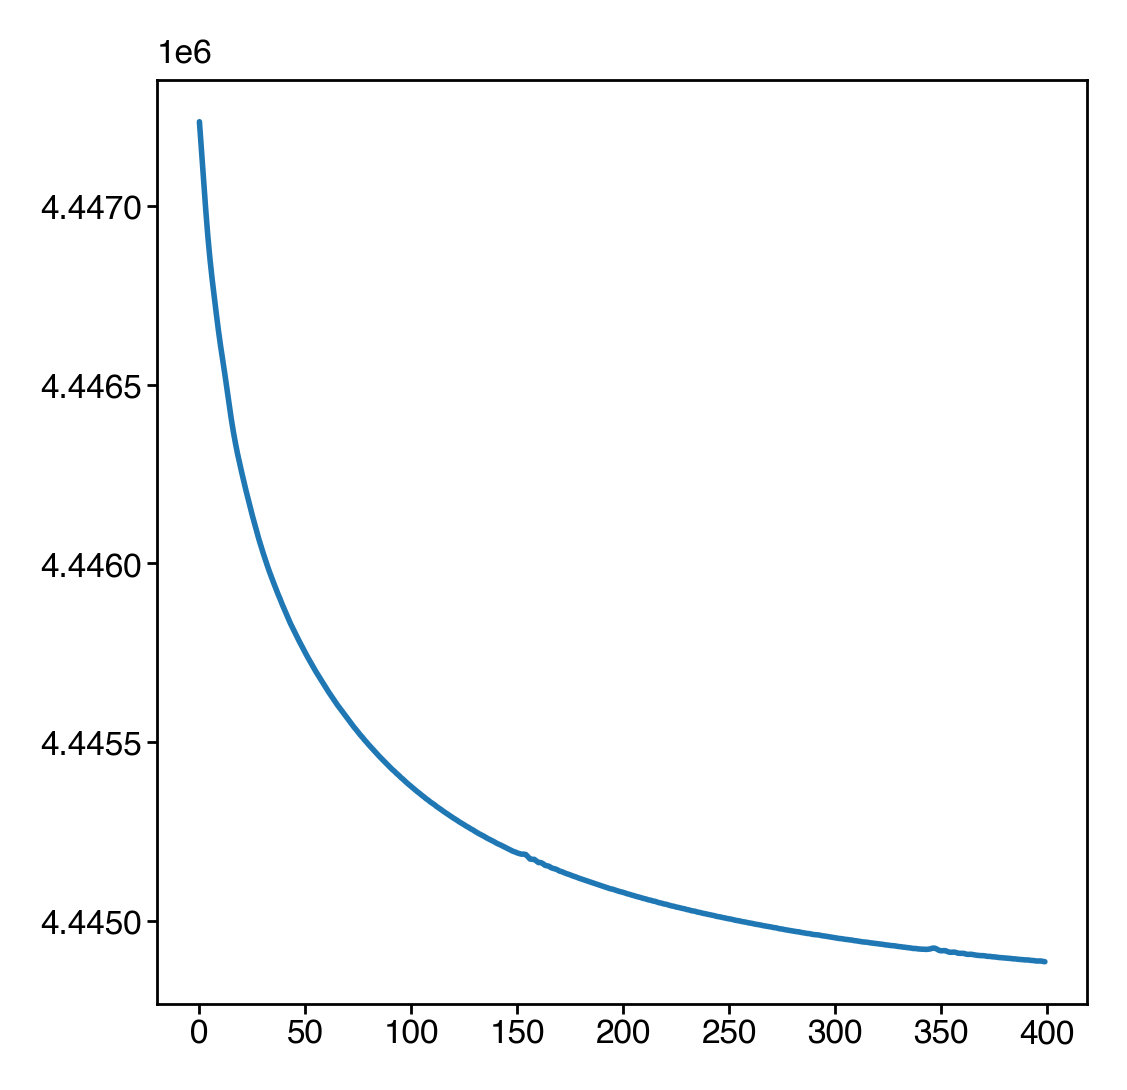

In [19]:
plt.plot(mdl['loss'][50:])

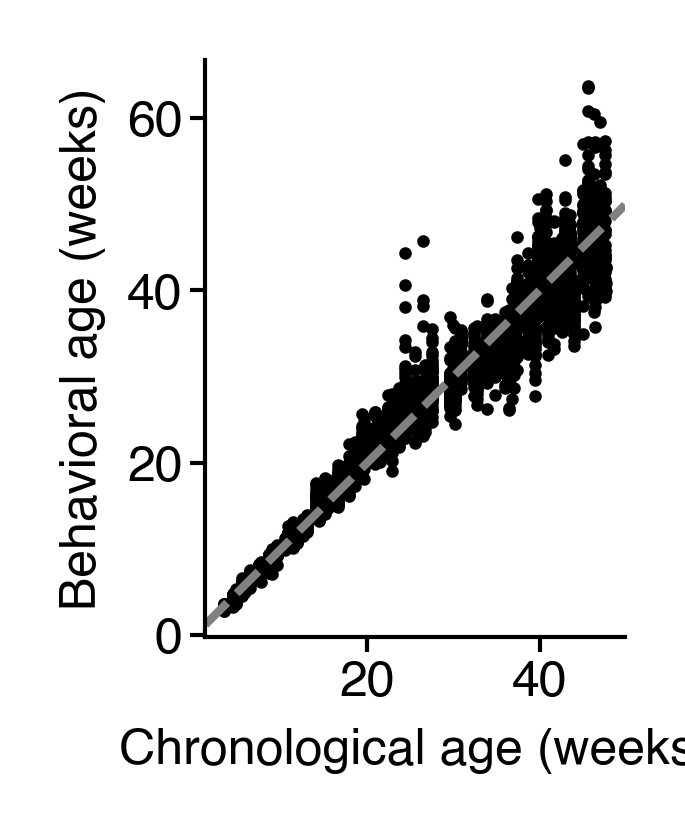

In [20]:
fig = figure(1.25, 1.25)
ax = fig.gca()
ax.scatter(mdl["true_ages"], mdl["bio_ages"], color="k", s=0.5)
ax.set(
    xlabel="Chronological age (weeks)",
    ylabel="Behavioral age (weeks)",
    aspect="equal",
    # xlim=(0, 150),
    # ylim=(0, 150),
)
add_identity(ax, color="gray", ls="--", zorder=1)
sns.despine()
# saver(fig, "ontogeny-female-bio-ages");

In [21]:
list(mdl['params'])

['bio_basis_weights',
 'development_weights',
 'individual_biases',
 'sex_biases',
 'sex_weights',
 'size_slope']

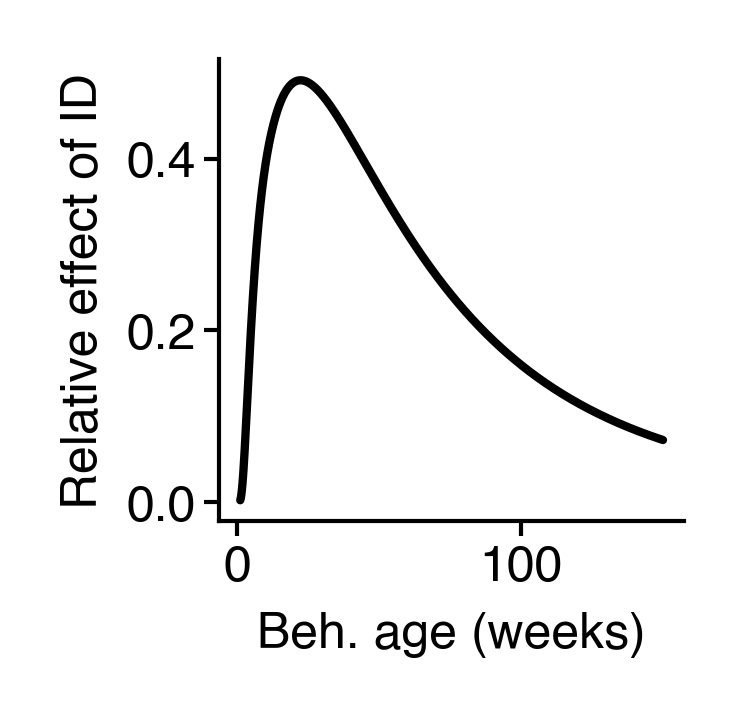

In [22]:
x = mdl['params']['development_weights']
dev = (x @ mdl['init_components'].bases['development']).squeeze()

comps = mdl['init_components']

dev = np.exp(dev)

fig = figure(1, 1)
ax = fig.gca()
ax.plot(comps.age_unnormalizer(comps.age_samples), dev, color='k')
# plt.xlim(0, 60)
# plt.ylim(0, 0.6)
plt.xlabel("Beh. age (weeks)")
plt.ylabel("Relative effect of ID")
sns.despine()
# ax.axvline(50, color='silver', ls='--')
# saver(fig, "ontogeny-effect-of-sex");

In [23]:
list(mdl['init_components'].bases)

['bio', 'size', 'individual', 'sex_id', 'development', 'sex']

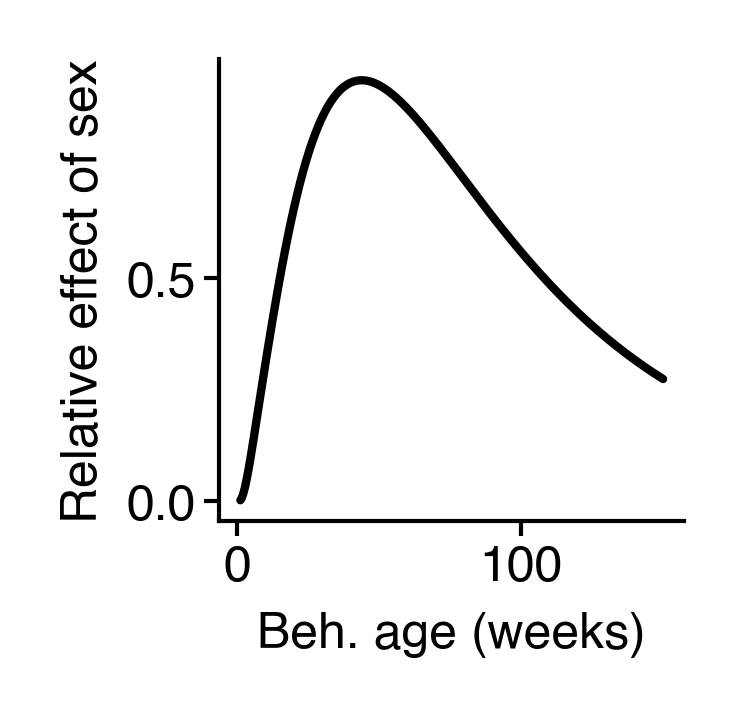

In [24]:
x = mdl['params']['sex_weights']
dev = (x @ mdl['init_components'].bases['sex']).squeeze()

comps = mdl['init_components']

dev = np.exp(dev)

fig = figure(1, 1)
ax = fig.gca()
ax.plot(comps.age_unnormalizer(comps.age_samples), dev, color='k')
# plt.xlim(0, 60)
# plt.ylim(0, 1.2)
plt.xlabel("Beh. age (weeks)")
plt.ylabel("Relative effect of sex")
sns.despine()
# ax.axvline(50, color='silver', ls='--')
# saver(fig, "ontogeny-effect-of-sex");